In [ ]:
import itertools
from functools import partial

import numpy as np
from tqdm import tqdm

import jax
jax.config.update("jax_default_matmul_precision", "highest")
import jax.numpy as jnp
from jax_tqdm import scan_tqdm

from gauge_field_utils import coef_to_lie_group, wilson_action, mean_wilson_rectangle, accurate_wilson_hamiltonian_error
from integrators import int_LF2, int_MN2_omelyan, int_MN4_takaishi_forcrand

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def HMC(beta, afn, nfev_approx):
    action_fn = lambda x: afn(coef_to_lie_group(x), beta)
    action_grad_fn = jax.grad(action_fn)
    
    def step_fn(coef, tau, random_key):
        key1, key2 = jax.random.split(random_key, num=2)
        p0 = jax.random.normal(key1, shape=coef.shape, dtype=coef.dtype)

        coef_prop, pt = int_MN4_takaishi_forcrand(coef, p0, action_grad_fn, tau, nfev_approx)
        dH = accurate_wilson_hamiltonian_error(coef, p0, coef_prop, pt, beta)

        p_acc = jnp.minimum(1, jnp.exp(-dH))

        coef_next = jax.lax.cond(
            jax.random.uniform(key2) < p_acc,
            lambda: coef_prop,
            lambda: coef
        )

        return coef_next, (dH, p_acc)

    return step_fn

def warmup_tint(coef, beta, random_key, observable_fn, tau, iters=2000, nfev_approx=20):
    stepper_fn = jax.jit(HMC(beta, wilson_action, nfev_approx))
    
    @scan_tqdm(iters, print_rate=1, tqdm_type="notebook")
    def warmup_step(carry, step):
        coef, rng_key, running_p_acc = carry
        rng_key, k1 = jax.random.split(rng_key)
        
        coef, (dH, p_acc) = stepper_fn(coef, tau, k1)
        running_p_acc = (running_p_acc * step + p_acc) / (step + 1)
        o = observable_fn(coef)
        jax.debug.print("warmup step {step} ; o={o} ; dH={dH} ; p_acc={p_acc}", step=step, o=o, dH=dH, p_acc=running_p_acc)

        carry = (coef, rng_key, running_p_acc)
        return carry, o

    (coef, *_), O = jax.lax.scan(
        warmup_step,
        init=(coef, random_key, 0),
        xs=np.arange(iters),
        length=iters
    )

    return coef, O

@partial(jax.jit, static_argnames=["R_range", "T_range"])
def calculate_wilson_loops(gauge_coef, R_range, T_range):
    R_min, R_max = R_range
    T_min, T_max = T_range
    wilson_loop_values = jnp.array([mean_wilson_rectangle(coef_to_lie_group(gauge_coef), R, T, time_unique=False) for R, T in itertools.product(range(R_min, R_max+1), range(T_min, T_max+1))]).reshape(R_max-R_min+1, T_max-T_min+1)
    return wilson_loop_values

In [3]:
L = (48, 16, 16, 16)

random_key, key1, key2 = jax.random.split(jax.random.key(0), num=3)
coef = jax.random.normal(key1, shape=(*L, 4, 8), dtype=jnp.float32)

In [4]:
coef, O = warmup_tint(
    coef,
    beta=6.586,
    random_key=random_key,
    observable_fn=jax.jit(lambda x: mean_wilson_rectangle(coef_to_lie_group(x), 3, 3, time_unique=False).real),
    tau=2.0,
    iters=300,
    nfev_approx=40
)

2025-03-13 04:08:30.852567: W external/xla/xla/hlo/transforms/host_offloader.cc:360] Token parameters are not supported for streaming.


warmup step 0 ; o=0.0015569408424198627 ; dH=1.1511077880859375 ; p_acc=0.31628620624542236


Running for 1,000 iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

warmup step 1 ; o=0.0015569408424198627 ; dH=1.1582183837890625 ; p_acc=0.3151656985282898
warmup step 2 ; o=0.0015569408424198627 ; dH=1.15203857421875 ; p_acc=0.3154411315917969
warmup step 3 ; o=0.0015569408424198627 ; dH=1.13720703125 ; p_acc=0.31675922870635986
warmup step 4 ; o=0.0015569408424198627 ; dH=1.127655029296875 ; p_acc=0.31816571950912476
warmup step 5 ; o=-0.0006765549769625068 ; dH=1.158447265625 ; p_acc=0.31746700406074524
warmup step 6 ; o=-0.00022302356956060976 ; dH=-0.203948974609375 ; p_acc=0.4149717390537262
warmup step 7 ; o=0.0009784051217138767 ; dH=0.108978271484375 ; p_acc=0.4751940071582794
warmup step 8 ; o=0.0009784051217138767 ; dH=0.421112060546875 ; p_acc=0.495318740606308
warmup step 9 ; o=0.0009784051217138767 ; dH=0.439605712890625 ; p_acc=0.5102159380912781
warmup step 10 ; o=0.0009784051217138767 ; dH=0.4587249755859375 ; p_acc=0.5212953686714172
warmup step 11 ; o=0.0006740870885550976 ; dH=0.4796142578125 ; p_acc=0.5294393301010132
warmup ste

In [6]:
wilson_loops = []

stepper_fn = jax.jit(HMC(6.586, wilson_action, nfev_approx=40))

for i in (bar := tqdm(range(3000))):
    random_key, key1 = jax.random.split(random_key)
    coef, (dH, p_acc) = stepper_fn(coef, tau=2.0, random_key=key1)

    # Calculate wilson loops
    wilson_loops.append(calculate_wilson_loops(coef, (1, 16), (1, 24)))

    bar.set_postfix({"dH": dH})

  0%|          | 0/3000 [00:00<?, ?it/s]

 74%|███████▍  | 2227/3000 [5:14:02<1:49:00,  8.46s/it, dH=-0.023330688]  


KeyboardInterrupt: 

In [2]:
wilson_loops = jnp.load("wilson_loops_beta_6p0.npy")

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



W0000 00:00:1742005766.406409  227826 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1742005766.420349  227826 service.cc:145] XLA service 0x1203f7220 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742005766.420364  227826 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1742005766.422653  227826 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1742005766.422667  227826 mps_client.cc:384] XLA backend will use up to 5726240768 bytes on device 0 for SimpleAllocator.


In [3]:
wilson_loops = np.array(wilson_loops)
mean_loops = np.real(wilson_loops.mean(axis=0)).copy()
omrt_loops = 1 - mean_loops/3

In [5]:
wilson_loops.shape

(2227, 16, 16)

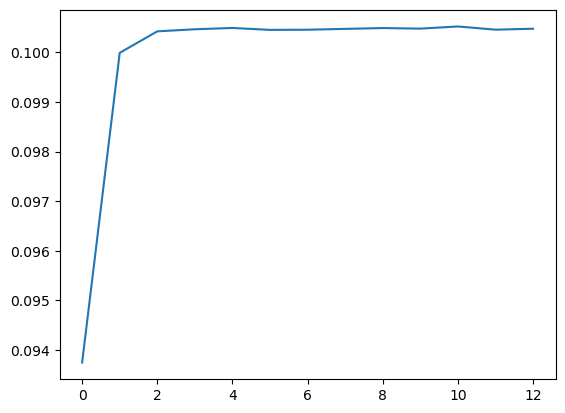

In [6]:
plt.plot((-np.diff(np.log(mean_loops), axis=1))[:-3, 8])
plt.show()

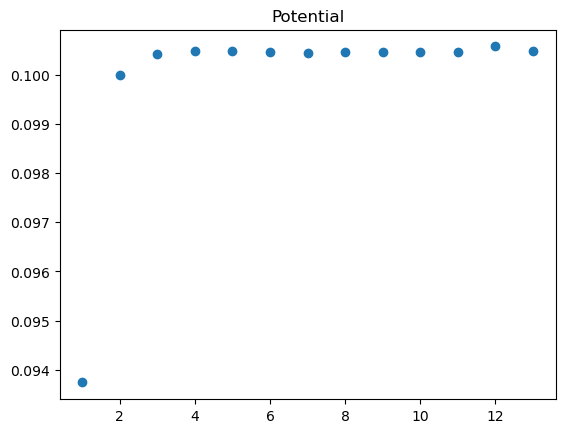

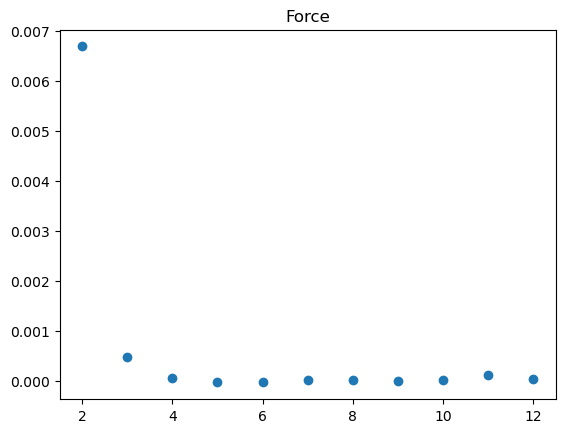

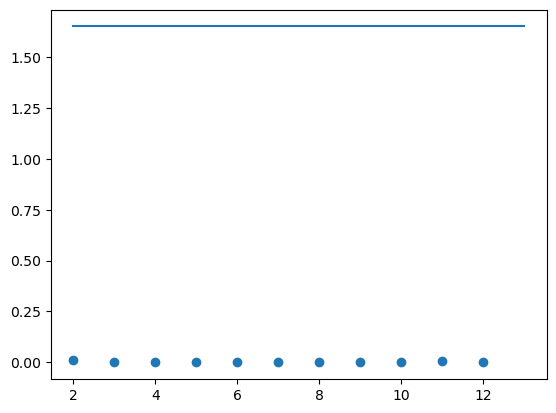

In [76]:
T = 7

x = 1+np.arange(len(mean_loops[:-3,T]))
V_values = np.log(mean_loops[:-3,T]/mean_loops[:-3,T+1])
plt.scatter(x, V_values)
plt.title("Potential")
plt.show()

plt.scatter(np.arange(2, 13), V_values[2:] - V_values[:-2])
plt.title("Force")
plt.show()

C = 1.65

x_F, a2F_values = np.arange(2, 13), (V_values[2:] - V_values[:-2]) / 2
plt.scatter(x_F, x_F*x_F*a2F_values)
plt.plot(np.linspace(2, 13, 100), np.full(100, C))
plt.show()

In [ ]:
V = V0 + a/r + sigma*r

F = -a/r^2 + sigma
sigma*r^2 - a = C


In [80]:
sigma, V0, alpha = np.polyfit(
    1+jnp.arange(L).astype(jnp.float32),
    jnp.log(mean_loops[:-3,7] / mean_loops[:-3,8]) * (1+jnp.arange(L)),
    deg=2
)

In [81]:
sigma

np.float64(-6.601970631640804e-05)

In [77]:
start, end = (0, -3)
for T in range(mean_loops[start:end].shape[0]-1):
    L = mean_loops[start:end].shape[0]
    V = np.log(mean_loops[:-2, T] / mean_loops[:-2, T+1])

    sigma, V0, alpha = np.polyfit(
        1+jnp.arange(L).astype(jnp.float32),
        jnp.log(mean_loops[start:end,T] / mean_loops[start:end,T+1]) * (1+jnp.arange(L)),
        deg=2
    )
    print(sigma, np.sqrt(np.abs(sigma)), np.sqrt(np.abs(sigma))/440*1000/5.068)

0.0061647199414350375 0.07851573053493827 0.03521011091650744
0.0003359449374211246 0.01832880076331031 0.008219488036929717
-3.300136798149393e-05 0.005744681712810025 0.0025761828732914303
-0.00010161843154575925 0.010080596785198744 0.004520609163198117
-7.876158356072002e-05 0.008874772310359293 0.003979861300118074
-7.984823697096723e-05 0.008935784071415738 0.0040072218157672645
-0.00010441564447753325 0.010218397353672113 0.004582405356995818
-6.601970631640804e-05 0.008125251154051057 0.0036437411001520492
-7.902780225823284e-05 0.008889758278954094 0.003986581706498033
-7.664914671834059e-05 0.008754949840995127 0.0039261273233995525
-7.054695746043557e-05 0.008399223622480566 0.0037666031169192467
-0.00010660738794953908 0.010325085372506083 0.004630249234280191


In [95]:
sigma, V0, alpha = np.polyfit(
    1+jnp.arange(13+1).astype(jnp.float32),
    jnp.log(mean_loops[:-2,-2] / mean_loops[:-2,-1]) * (1+jnp.arange(13+1)),
    deg=2
)

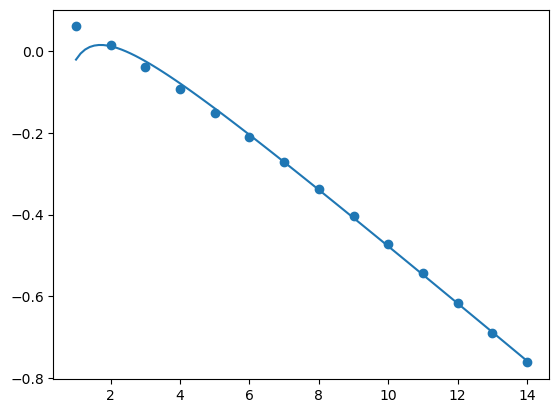

In [96]:
x = 1+jnp.linspace(0, 13, 100)
y = V0 + alpha / x + sigma * x

plt.scatter(1+jnp.arange(13+1), jnp.log(mean_loops[:-2,-2] / mean_loops[:-2,-1]))
plt.plot(x, y)
plt.show()

In [98]:
jnp.sqrt(np.abs(sigma)) / 440 * 1000 * 0.1973164956590371

Array(0.11995274, dtype=float32)